# Configuration
## General Imports

In [2]:
# General Tools/Utilities
from pathlib import Path
import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
import warnings
from multiprocessing import Pool, cpu_count
import re
from typing import List, Tuple
import buckaroo
from tqdm import tqdm
import gc
from fuzzywuzzy import fuzz, process
# Warnings
import warnings
warnings.filterwarnings('ignore')

Buckaroo has been enabled as the default DataFrame viewer.  To return to default dataframe visualization use `from buckaroo import disable; disable()`
must be running inside ipython to enable default display via enable()


## ML Imports

In [3]:
# Machine Learning Imports
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb

## Custom Imports

In [4]:
# Custom Imports
from data_loader import DataLoader
from jse_companies import jse_company_names
from technical_indicators import add_all_indicators, filter_buy_signals, get_signals_summary
from data import MarketDataPipeline

# Get Data

In [5]:
# Load stock data
pipeline = MarketDataPipeline(DataLoader(), jse_company_names)

df = pipeline.load_stock_data(
    start_date='2017-01-01', 
    end_date='2025-03-31'
)

In [7]:
# Add technical Indicators
technical_df = add_all_indicators(df, price_col="closing_price", symbol = 'all')

# Expiriment with LSTM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from typing import Tuple, Optional, List
import warnings
warnings.filterwarnings('ignore')


class LSTMStockPredictor:
    """
    LSTM-based stock price prediction model using Polars for data handling
    """
    
    def __init__(self, prediction_days: int = 60, lstm_units: int = 50, dropout_rate: float = 0.2):
        """
        Initialize the LSTM Stock Predictor
        
        Args:
            prediction_days: Number of days to look back for prediction (default: 60)
            lstm_units: Number of LSTM units in each layer (default: 50)
            dropout_rate: Dropout rate for regularization (default: 0.2)
        """
        self.prediction_days = prediction_days
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.is_trained = False
        
    def prepare_data(self, df: pl.DataFrame, price_col: str = "closing_price", 
                    symbol: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare data for LSTM training
        
        Args:
            df: Polars DataFrame with stock data
            price_col: Column name for price data
            symbol: Specific symbol to prepare data for (optional)
        
        Returns:
            Tuple of (X_train, y_train) arrays
        """
        # Filter for specific symbol if provided
        if symbol:
            data = df.filter(pl.col("symbol") == symbol).sort("date")
        else:
            data = df.sort("date")
        
        # Extract closing prices and convert to float
        prices = data[price_col].cast(pl.Float64).to_numpy().reshape(-1, 1)
        
        # Scale the data
        scaled_data = self.scaler.fit_transform(prices)
        
        # Create training sequences
        x_train, y_train = [], []
        
        for i in range(self.prediction_days, len(scaled_data)):
            x_train.append(scaled_data[i-self.prediction_days:i, 0])
            y_train.append(scaled_data[i, 0])
        
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        # Reshape for LSTM input (samples, timesteps, features)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        return x_train, y_train
    
    def build_model(self, input_shape: Tuple[int, int]) -> None:
        """
        Build the LSTM model architecture
        
        Args:
            input_shape: Shape of input data (timesteps, features)
        """
        self.model = Sequential([
            # First LSTM layer
            LSTM(units=self.lstm_units, return_sequences=True, input_shape=input_shape),
            Dropout(self.dropout_rate),
            
            # Second LSTM layer
            LSTM(units=self.lstm_units, return_sequences=True),
            Dropout(self.dropout_rate),
            
            # Third LSTM layer
            LSTM(units=self.lstm_units, return_sequences=False),
            Dropout(self.dropout_rate),
            
            # Output layer
            Dense(units=1)
        ])
        
        # Compile the model
        self.model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mae']
        )
        
        print("Model architecture:")
        self.model.summary()
    
    def train(self, x_train: np.ndarray, y_train: np.ndarray, 
             epochs: int = 25, batch_size: int = 32, validation_split: float = 0.1,
             verbose: int = 1) -> dict:
        """
        Train the LSTM model
        
        Args:
            x_train: Training features
            y_train: Training targets
            epochs: Number of training epochs
            batch_size: Training batch size
            validation_split: Fraction of data for validation
            verbose: Training verbosity
        
        Returns:
            Training history dictionary
        """
        if self.model is None:
            input_shape = (x_train.shape[1], x_train.shape[2])
            self.build_model(input_shape)
        
        # Callbacks for better training
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
        ]
        
        # Train the model
        history = self.model.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=verbose
        )
        
        self.is_trained = True
        print(f"Training completed. Final loss: {history.history['loss'][-1]:.6f}")
        
        return history.history
    
    def predict(self, x_test: np.ndarray) -> np.ndarray:
        """
        Make predictions using the trained model
        
        Args:
            x_test: Test features
        
        Returns:
            Predictions array
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        predictions = self.model.predict(x_test, verbose=0)
        # Inverse transform to get actual price predictions
        predictions = self.scaler.inverse_transform(predictions)
        
        return predictions.flatten()
    
    def prepare_test_data(self, train_df: pl.DataFrame, test_df: pl.DataFrame,
                         price_col: str = "closing_price", symbol: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare test data for prediction
        
        Args:
            train_df: Training data DataFrame
            test_df: Test data DataFrame
            price_col: Column name for price data
            symbol: Specific symbol to prepare data for
        
        Returns:
            Tuple of (X_test, actual_prices)
        """
        # Filter for specific symbol if provided
        if symbol:
            train_data = train_df.filter(pl.col("symbol") == symbol).sort("date")
            test_data = test_df.filter(pl.col("symbol") == symbol).sort("date")
        else:
            train_data = train_df.sort("date")
            test_data = test_df.sort("date")
        
        # Get actual test prices and convert to float
        actual_prices = test_data[price_col].cast(pl.Float64).to_numpy()
        
        # Combine train and test data for proper scaling context
        combined_prices = pl.concat([
            train_data.select([price_col]),
            test_data.select([price_col])
        ])[price_col].cast(pl.Float64).to_numpy().reshape(-1, 1)
        
        # Use the same scaler fitted on training data
        scaled_combined = self.scaler.transform(combined_prices)
        
        # Extract the portion needed for test predictions
        model_inputs = scaled_combined[len(scaled_combined) - len(test_data) - self.prediction_days:]
        
        # Create test sequences
        x_test = []
        for i in range(self.prediction_days, len(model_inputs)):
            x_test.append(model_inputs[i-self.prediction_days:i, 0])
        
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        
        return x_test, actual_prices
    
    def plot_predictions(self, actual_prices: np.ndarray, predicted_prices: np.ndarray,
                        symbol: str = "Stock", save_path: Optional[str] = None) -> None:
        """
        Plot actual vs predicted prices
        
        Args:
            actual_prices: Array of actual stock prices
            predicted_prices: Array of predicted stock prices
            symbol: Stock symbol for plot title
            save_path: Path to save the plot (optional)
        """
        plt.figure(figsize=(12, 6))
        plt.plot(actual_prices, color='black', label=f"Actual {symbol} Price", linewidth=2)
        plt.plot(predicted_prices, color='green', label=f"Predicted {symbol} Price", linewidth=2)
        plt.title(f"{symbol} Stock Price Prediction", fontsize=16)
        plt.xlabel('Time (Days)', fontsize=12)
        plt.ylabel(f'{symbol} Price', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Calculate and display metrics
        actual_prices = np.array(actual_prices, dtype=np.float64)
        predicted_prices = np.array(predicted_prices, dtype=np.float64)
        
        mae = np.mean(np.abs(actual_prices - predicted_prices))
        rmse = np.sqrt(np.mean((actual_prices - predicted_prices) ** 2))
        mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
        
        print(f"\nPrediction Metrics for {symbol}:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    def predict_next_day(self, recent_data: np.ndarray) -> float:
        """
        Predict the next day's stock price
        
        Args:
            recent_data: Recent price data (should have at least prediction_days values)
        
        Returns:
            Next day price prediction
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        if len(recent_data) < self.prediction_days:
            raise ValueError(f"Need at least {self.prediction_days} days of recent data")
        
        # Convert to float array to handle Decimal types
        recent_data_float = np.array(recent_data, dtype=np.float64)
        
        # Take the last prediction_days values
        recent_scaled = self.scaler.transform(recent_data_float[-self.prediction_days:].reshape(-1, 1))
        
        # Reshape for prediction
        prediction_input = recent_scaled.reshape(1, self.prediction_days, 1)
        
        # Make prediction
        prediction = self.model.predict(prediction_input, verbose=0)
        prediction = self.scaler.inverse_transform(prediction)
        
        return float(prediction[0][0])


def train_multi_symbol_model(df: pl.DataFrame, symbols: List[str], 
                           price_col: str = "closing_price") -> dict:
    """
    Train LSTM models for multiple symbols
    
    Args:
        df: Polars DataFrame with stock data
        symbols: List of stock symbols to train models for
        price_col: Column name for price data
    
    Returns:
        Dictionary of trained models by symbol
    """
    models = {}
    
    for symbol in symbols:
        print(f"\n{'='*50}")
        print(f"Training model for {symbol}")
        print(f"{'='*50}")
        
        # Initialize model
        predictor = LSTMStockPredictor(prediction_days=60)
        
        # Prepare data for this symbol
        x_train, y_train = predictor.prepare_data(df, price_col, symbol)
        
        if len(x_train) < 100:  # Skip if insufficient data
            print(f"Insufficient data for {symbol} (only {len(x_train)} samples)")
            continue
        
        # Train the model
        history = predictor.train(x_train, y_train, epochs=50, batch_size=32)
        
        models[symbol] = predictor
        
    return models


# Example usage and testing function
def example_usage():
    """
    Example of how to use the LSTM Stock Predictor
    """
    print("LSTM Stock Price Prediction Example")
    print("="*40)
    
    # Create sample data
    np.random.seed(42)
    start_date = dt.date(2020, 1, 1)
    end_date = dt.date(2024, 1, 1)
    
    # Calculate number of days
    n = (end_date - start_date).days
    
    # Create date range
    dates = [start_date + dt.timedelta(days=i) for i in range(n)]
    
    # Generate realistic stock price data
    price_changes = np.random.normal(0.001, 0.02, n)  # Daily returns
    prices = [100.0]  # Starting price
    
    for change in price_changes[1:]:
        new_price = prices[-1] * (1 + change)
        prices.append(max(new_price, 1.0))  # Ensure price doesn't go negative
    
    # Create sample DataFrame
    sample_df = pl.DataFrame({
        "date": dates,
        "symbol": ["AAPL"] * n,
        "closing_price": prices,
        "volume": np.random.randint(1000000, 50000000, n)
    })
    
    # Split into train and test
    split_date = dt.date(2023, 1, 1)
    train_df = sample_df.filter(pl.col("date") < split_date)
    test_df = sample_df.filter(pl.col("date") >= split_date)
    
    print(f"Training data: {len(train_df)} days")
    print(f"Test data: {len(test_df)} days")
    
    # Initialize and train model
    predictor = LSTMStockPredictor(prediction_days=60)
    
    # Prepare training data
    x_train, y_train = predictor.prepare_data(train_df, "closing_price", "AAPL")
    print(f"Training sequences: {len(x_train)}")
    
    # Train the model
    history = predictor.train(x_train, y_train, epochs=25, batch_size=32)
    
    # Prepare test data and make predictions
    x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price", "AAPL")
    predicted_prices = predictor.predict(x_test)
    
    # Plot results
    predictor.plot_predictions(actual_prices, predicted_prices, "AAPL")
    
    # Make next day prediction
    recent_prices = test_df.tail(60)["closing_price"].to_numpy()
    next_day_prediction = predictor.predict_next_day(recent_prices)
    current_price = recent_prices[-1]
    
    print(f"\nNext Day Prediction:")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Predicted Price: ${next_day_prediction:.2f}")
    print(f"Predicted Change: {((next_day_prediction - current_price) / current_price * 100):+.2f}%")
    
    return predictor


if __name__ == "__main__":
    #example_usage()
    pass

Training data: 1888 days
Test data: 61 days
Model architecture:


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0800 - mae: 0.1989 - val_loss: 3.3442e-04 - val_mae: 0.0146 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0035 - mae: 0.0421 - val_loss: 2.1686e-04 - val_mae: 0.0112 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0035 - mae: 0.0420 - val_loss: 3.7149e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0032 - mae: 0.0404 - val_loss: 1.5398e-04 - val_mae: 0.0099 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0034 - mae: 0.0418 - val_loss: 1.2030e-04 - val_mae: 0.0090 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0028 - mae: 0.0373 - val_loss: 2.0504e-04 - val_mae: 0.0109 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0025 - mae: 0.0355 - val_loss: 1.2495e-04 - val_mae: 0.0093 - 

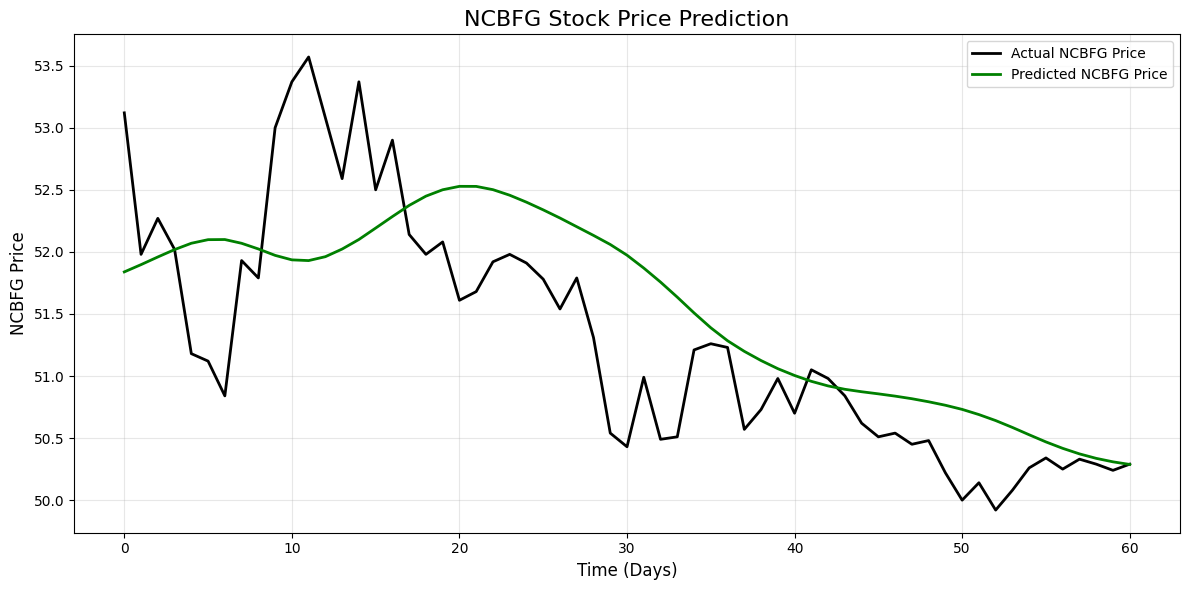


Prediction Metrics for NCBFG:
Mean Absolute Error (MAE): 0.56
Root Mean Square Error (RMSE): 0.71
Mean Absolute Percentage Error (MAPE): 1.08%

Next Day Prediction for NCBFG:
Current Price: $50.29
Predicted Price: $50.27
Predicted Change: -0.03%


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\framework\ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


In [ ]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2024, 9, 30)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = technical_df.filter(pl.col("symbol") == "NCBFG").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=60)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=100, batch_size=32)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "NCBFG")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for NCBFG:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

Training data: 1888 days
Test data: 61 days
Model architecture:


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0455 - mae: 0.1371 - val_loss: 4.0729e-04 - val_mae: 0.0166 - learning_rate: 0.0010
Epoch 2/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0037 - mae: 0.0433 - val_loss: 1.2863e-04 - val_mae: 0.0091 - learning_rate: 0.0010
Epoch 3/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0030 - mae: 0.0389 - val_loss: 3.9254e-04 - val_mae: 0.0169 - learning_rate: 0.0010
Epoch 4/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0033 - mae: 0.0409 - val_loss: 4.3862e-04 - val_mae: 0.0181 - learning_rate: 0.0010
Epoch 5/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0030 - mae: 0.0387 - val_loss: 1.2720e-04 - val_mae: 0.0086 - learning_rate: 0.0010
Epoch 6/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0027 - mae: 0.0367 - val_loss: 2.0213e-04 - val_mae: 0.0112 - learning_rate: 0.0010
Epoch 7/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0030 - mae: 0.0382 - val_loss: 2.9695e-04 - val_mae: 0.0142 - 

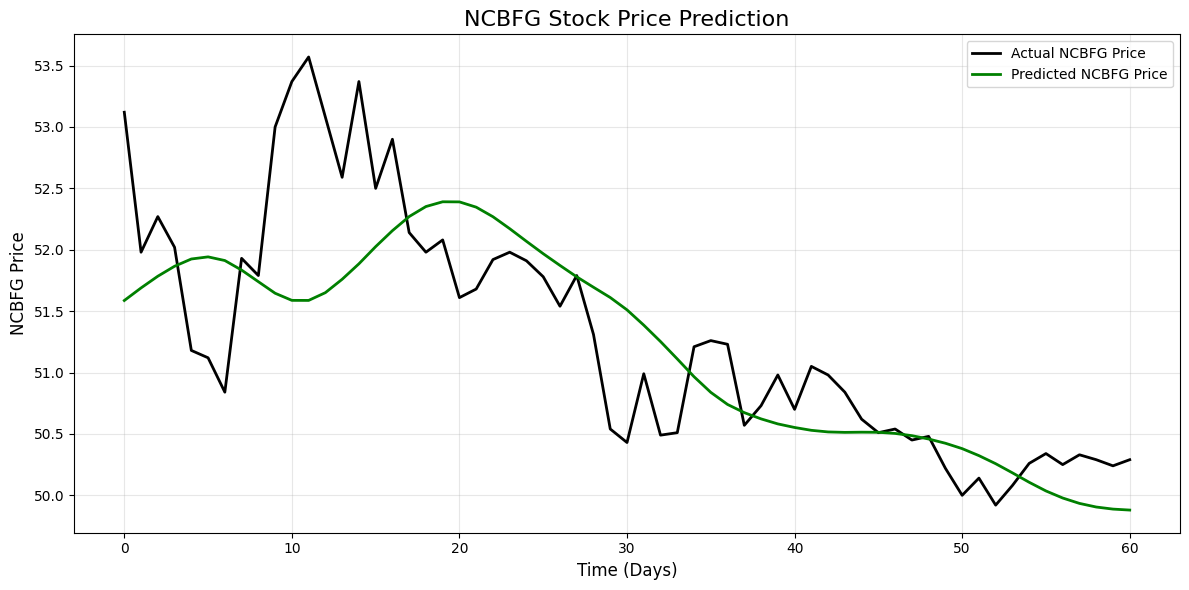


Prediction Metrics for NCBFG:
Mean Absolute Error (MAE): 0.49
Root Mean Square Error (RMSE): 0.67
Mean Absolute Percentage Error (MAPE): 0.95%

Next Day Prediction for NCBFG:
Current Price: $50.29
Predicted Price: $49.88
Predicted Change: -0.82%


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\framework\ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


In [17]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2024, 9, 30)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = technical_df.filter(pl.col("symbol") == "NCBFG").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=60)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=150, batch_size=20)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "NCBFG")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for NCBFG:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")

Training data: 1888 days
Test data: 61 days
Model architecture:


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0377 - mae: 0.1334 - val_loss: 4.2611e-04 - val_mae: 0.0169 - learning_rate: 0.0010
Epoch 2/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0035 - mae: 0.0428 - val_loss: 3.8577e-04 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 3/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0031 - mae: 0.0395 - val_loss: 3.2934e-04 - val_mae: 0.0144 - learning_rate: 0.0010
Epoch 4/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0032 - mae: 0.0400 - val_loss: 7.4754e-04 - val_mae: 0.0251 - learning_rate: 0.0010
Epoch 5/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0028 - mae: 0.0383 - val_loss: 1.2691e-04 - val_mae: 0.0091 - learning_rate: 0.0010
Epoch 6/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0028 - mae: 0.0379 - val_loss: 1.0919e-04 - val_mae: 0.0084 - learning_rate: 0.0010
Epoch 7/250
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0026 - mae: 0.0357 - val_loss: 8.9953e-04 - val_mae: 0.0282 - 

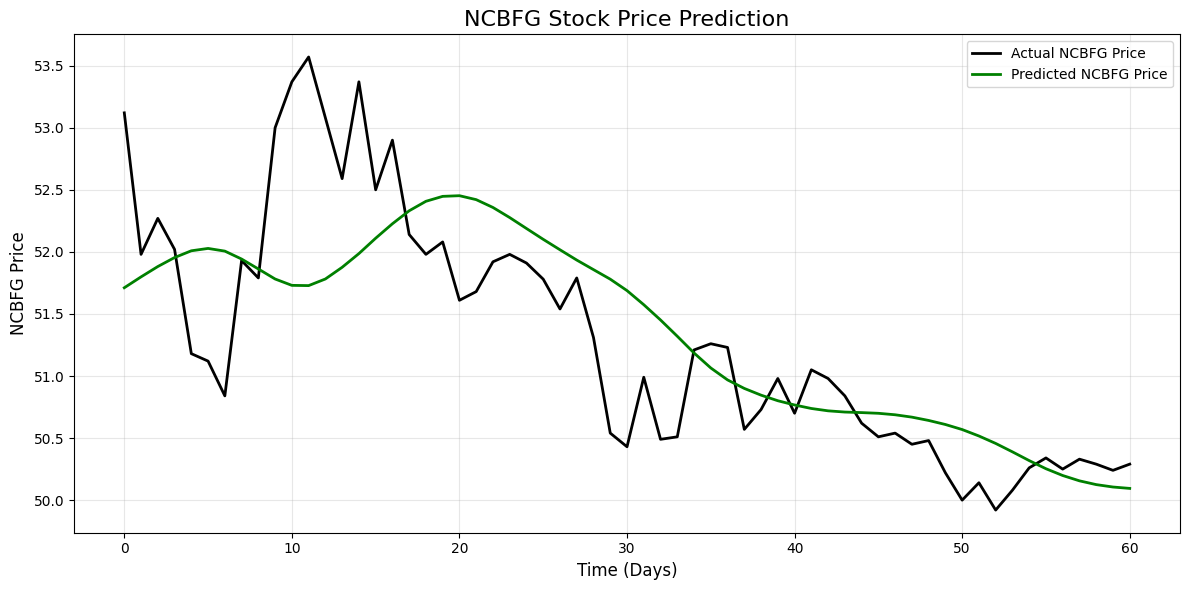


Prediction Metrics for NCBFG:
Mean Absolute Error (MAE): 0.49
Root Mean Square Error (RMSE): 0.66
Mean Absolute Percentage Error (MAPE): 0.95%

Next Day Prediction for NCBFG:
Current Price: $50.29
Predicted Price: $50.09
Predicted Change: -0.40%


c:\Users\Joshh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\framework\ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


In [20]:
import datetime as dt

# Split your data into training and testing sets
split_date = dt.date(2024, 9, 30)  # Adjust this date as needed

# Filter your stocks_df for the specific symbol first, then split
fosrich_data = technical_df.filter(pl.col("symbol") == "NCBFG").sort("date")

# Split into train and test
train_df = fosrich_data.filter(pl.col("date") < split_date)
test_df = fosrich_data.filter(pl.col("date") >= split_date)

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Now you can use the predictor
predictor = LSTMStockPredictor(prediction_days=60)

# Prepare training data
x_train, y_train = predictor.prepare_data(train_df, "closing_price")
history = predictor.train(x_train, y_train, epochs=250, batch_size=30)

# Make predictions on test data
x_test, actual_prices = predictor.prepare_test_data(train_df, test_df, "closing_price")
predicted_prices = predictor.predict(x_test)

# Plot results with metrics
predictor.plot_predictions(actual_prices, predicted_prices, "NCBFG")

# Predict next day
recent_prices = test_df.tail(60)["closing_price"].to_numpy()
next_day_prediction = predictor.predict_next_day(recent_prices)
current_price = recent_prices[-1]

print(f"\nNext Day Prediction for NCBFG:")
print(f"Current Price: ${float(current_price):.2f}")
print(f"Predicted Price: ${next_day_prediction:.2f}")

# Convert both to float for the calculation
change_pct = ((next_day_prediction - float(current_price)) / float(current_price) * 100)
print(f"Predicted Change: {change_pct:+.2f}%")